In [1]:
from astropy.io import fits
from astropy.wcs import WCS

f = fits.open('/home/regier/bliss/data/sdss/2583/2/136/frame-r-002583-2-0136.fits')
w = WCS(f[0].header)

# lower-left corner of the 100x100-pixel study area is at pixel (310, 630)
w.pixel_to_world(310, 630)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (323.33025022, -0.81252688)>

In [2]:
import pandas as pd

# catalog from https://catalogs.mast.stsci.edu/hsc/
# target: 323.3357504,-0.807026
# radius of 32 arcsec; v3; detailed; MagAuto <= 24
fn = '/home/regier/bliss/case_studies/dependent_tiling/HSC-10_20_2023.csv'
hst_catalog = pd.read_csv(fn)
hst_catalog

,CatID,MatchID,MemID,SourceID,ImageID,MatchRA,MatchDec,SourceRA,SourceDec,WaveLength,Filter,TargetName,FluxAper2,MagAper2,MagAuto
0,330971847,105755457,2,4001444529780,33543,323.343113,-0.807900,323.343113,-0.807900,8047.6714,F814W,NGC7089,21.006599,22.649401,22.066500
1,387645511,32764845,3,6000234549762,1030041,323.343052,-0.807789,323.343052,-0.807789,4325.0000,F438W,NGC-7089-M-2,51.702801,20.572800,20.527000
2,330790895,32764845,1,4001444529965,33543,323.343052,-0.807789,323.343052,-0.807789,5919.2002,F606W,NGC7089,344.691010,20.167400,20.109501
3,330972017,32764845,2,4001444529965,33543,323.343052,-0.807789,323.343052,-0.807789,8047.6714,F814W,NGC7089,232.296005,20.040199,19.945400
4,330791696,38448905,1,4001444530887,33543,323.343120,-0.807458,323.343120,-0.807458,5919.2002,F606W,NGC7089,37.894699,22.564501,22.516300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9568,330958676,40009577,2,4001444515400,33543,323.337783,-0.813340,323.337783,-0.813341,8047.6714,F814W,NGC7089,48.524899,21.740299,21.513599
9569,388837531,40009577,4,6000234462528,1030041,323.337783,-0.813340,323.337784,-0.813339,4325.0000,F438W,NGC-7089-M-2,8.431490,22.541800,22.476500
9570,388837532,40009577,3,6000234462528,1030041,323.337783,-0.813340,323.337784,-0.813339,3354.8999,F336W,NGC-7089-M-2,2.224480,23.839500,23.775700
9571,388710893,39235744,5,6000234461911,1030041,323.338007,-0.813668,323.338007,-0.813668,4325.0000,F438W,NGC-7089-M-2,33.755402,21.035700,21.009100


In [3]:
from astropy.coordinates import SkyCoord

hst_coords = SkyCoord(ra=hst_catalog['MatchRA'], dec=hst_catalog['MatchDec'], unit='deg')
hst_pix = w.world_to_pixel(hst_coords)

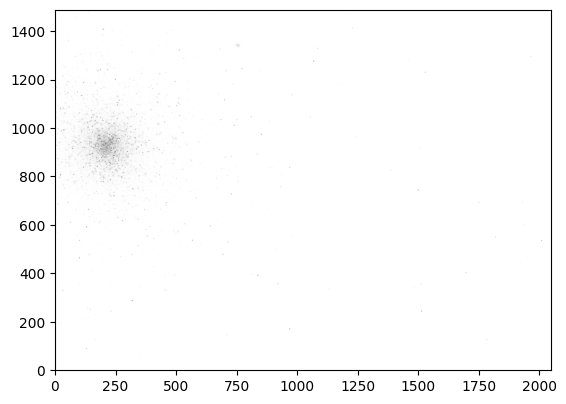

In [4]:
from matplotlib import pyplot as plt

plt.imshow(f[0].data, origin='lower', cmap='gray_r')

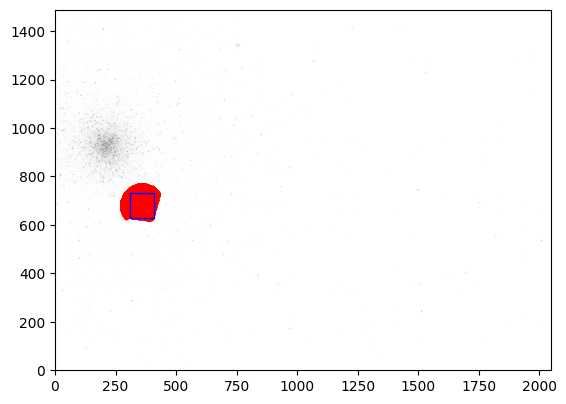

In [5]:
from matplotlib.patches import Rectangle

plt.imshow(f[0].data, origin='lower', cmap='gray_r')
plt.scatter(hst_pix[0], hst_pix[1], s=10, c='r')
rect = Rectangle((310, 630), 100, 100, linewidth=1, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect)


In [6]:
in_bounds = (hst_pix[0] > 310) & (hst_pix[0] < 410) & (hst_pix[1] > 630) & (hst_pix[1] < 730)
hst_inbounds = hst_catalog[in_bounds]

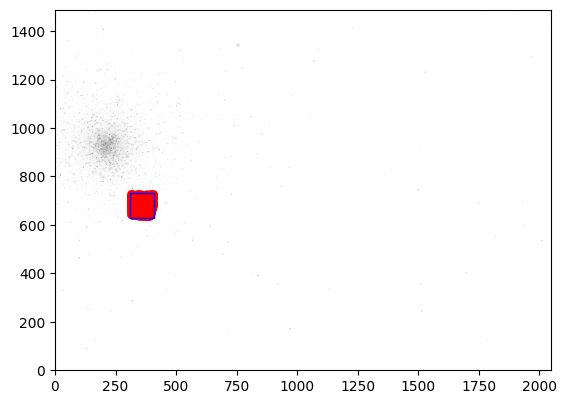

In [7]:
plt.imshow(f[0].data, origin='lower', cmap='gray_r')
plt.scatter(hst_pix[0][in_bounds], hst_pix[1][in_bounds], s=10, c='r')
rect = Rectangle((310, 630), 100, 100, linewidth=1, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect)

In [10]:
hst_inbounds["MatchID"].unique().shape

(2718,)

In [9]:
hst_inbounds

,CatID,MatchID,MemID,SourceID,ImageID,MatchRA,MatchDec,SourceRA,SourceDec,WaveLength,Filter,TargetName,FluxAper2,MagAper2,MagAuto
167,330971752,48197896,2,4001444529676,33543,323.336748,-0.807903,323.336748,-0.807903,8047.6714,F814W,NGC7089,19.046600,22.755699,22.641500
168,330793081,65103741,1,4001444532400,33543,323.336147,-0.806833,323.336147,-0.806833,5919.2002,F606W,NGC7089,261.785004,20.466101,20.384399
169,330974253,65103741,2,4001444532400,33543,323.336147,-0.806833,323.336147,-0.806833,8047.6714,F814W,NGC7089,158.990997,20.451799,20.319599
170,330793317,72967182,1,4001444532664,33543,323.336371,-0.806737,323.336371,-0.806737,5919.2002,F606W,NGC7089,9.598670,24.055401,23.578300
171,330974493,72967182,2,4001444532664,33543,323.336371,-0.806737,323.336371,-0.806737,8047.6714,F814W,NGC7089,10.906400,23.361099,22.978399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9457,330798803,65780816,1,4001444538719,33543,323.340767,-0.804232,323.340767,-0.804232,5919.2002,F606W,NGC7089,4.471030,24.884899,23.407900
9458,330979666,3060692,2,4001444538250,33543,323.340748,-0.804385,323.340748,-0.804385,8047.6714,F814W,NGC7089,46.845402,21.778601,21.577600
9459,330798380,3060692,1,4001444538250,33543,323.340748,-0.804385,323.340748,-0.804385,5919.2002,F606W,NGC7089,57.662201,22.108700,21.947599
9460,330979667,49697666,2,4001444538251,33543,323.340804,-0.804354,323.340804,-0.804354,8047.6714,F814W,NGC7089,64.178001,21.436800,20.938499
